In [47]:
import random
import numpy as np

class Node:
    """
    Đại diện cho một ô trên bản đồ.
    """
    def __init__(self, x, y, is_obstacle=False):
        self.x = x
        self.y = y
        self.is_obstacle = is_obstacle
        
        self.g = float('inf')
        self.h = 0.0
        self.f = float('inf')
        self.parent = None

    def get_pos(self):
        '''
        Lấy tọa độ (x, y) của node.
        '''
        return (self.x, self.y)

    def __lt__(self, other):
        '''
        So sánh hai node dựa trên giá trị f để sử dụng trong heapq.
        '''
        return self.f < other.f

class MazeMap:
    """
    Quản lý lưới mê cung, vật cản, điểm đầu/cuối.
    """
    def __init__(self, n):
        self.n = n
        self.grid = []
        self.start = (0, 0)
        self.goal = (n-1, n-1)
        self._init_grid()

    def _init_grid(self):
        self.grid = [[Node(r, c) for c in range(self.n)] for r in range(self.n)]

    def generate_random_map(self, density=0.2, manual_start=None, manual_goal=None):
        """
        Sinh bản đồ với tùy chọn Start/Goal thủ công hoặc ngẫu nhiên.
        Args:
            density: Mật độ vật cản.
            manual_start: Tuple (x, y) hoặc None.
            manual_goal: Tuple (x, y) hoặc None.
        """
        self._init_grid() # Reset lưới
        
        # 1. Xử lý điểm Start
        if manual_start:
            self.start = manual_start
        else:
            # Random toàn bộ sàn
            self.start = (random.randint(0, self.n-1), random.randint(0, self.n-1))
            
        # 2. Xử lý điểm Goal
        if manual_goal:
            self.goal = manual_goal
        else:
            # Random nhưng phải khác Start
            while True:
                r = random.randint(0, self.n-1)
                c = random.randint(0, self.n-1)
                if (r, c) != self.start:
                    self.goal = (r, c)
                    break
        
        # 3. Random vật cản
        num_obstacles = int(self.n * self.n * density)
        count = 0
        
        while count < num_obstacles:
            '''
            Sinh tọa độ ngẫu nhiên cho vật cản.
            '''
            r = random.randint(0, self.n - 1)
            c = random.randint(0, self.n - 1)
            
            # Điều kiện: Không trùng Start, Goal và chưa có vật cản
            if (r, c) != self.start and (r, c) != self.goal and not self.grid[r][c].is_obstacle:
                self.grid[r][c].is_obstacle = True
                count += 1

In [48]:
import heapq

class AStarSolver:
    """
    Thực thi thuật toán tìm kiếm A*.
    """
    def __init__(self, maze_map):
        self.map = maze_map
        self.open_set = []
        self.closed_set = set()

    def heuristic(self, node_a, pos_b):
        """
        Khoảng cách Manhattan - Start(x1, y1), Goal(x2, y2)
        h(n) = |x1 - x2| + |y1 - y2|
        Args:
            node_a: Node hiện tại.
            pos_b: Tuple (x, y) của điểm đích.
        Returns: Khoảng cách Manhattan giữa node_a và pos_b.
        """
        return abs(node_a.x - pos_b[0]) + abs(node_a.y - pos_b[1])

    def get_neighbors(self, node):
        """
        Lấy các ô lân cận không phải vật cản.
        Args:
            node: Node hiện tại.
        Returns: Danh sách Node lân cận.
        """
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)] # Lên, Xuống, Trái, Phải
        
        for dr, dc in directions:
            nr, nc = node.x + dr, node.y + dc
            if 0 <= nr < self.map.n and 0 <= nc < self.map.n:
                neighbor = self.map.grid[nr][nc]
                if not neighbor.is_obstacle:
                    neighbors.append(neighbor)
        return neighbors

    def solve(self):
        """
        Chạy thuật toán.
        Returns: (path, visited_history)
            - path: Danh sách tọa độ từ Start đến Goal nếu tìm thấy, else None.
            - visited_history: Danh sách các bước đã thăm với thông tin g, h
        """
        start_node = self.map.grid[self.map.start[0]][self.map.start[1]]
        goal_pos = self.map.goal
        
        start_node.g = 0
        start_node.h = self.heuristic(start_node, goal_pos)
        start_node.f = start_node.h
        
        heapq.heappush(self.open_set, start_node)
        
        visited_history = [] 

        while self.open_set:
            current = heapq.heappop(self.open_set)
            
            step_info = {
                'pos': current.get_pos(),
                'g': current.g,
                'h': current.h,
                'f': current.f
            }
            visited_history.append(step_info)

            if current.get_pos() == goal_pos:
                return self._reconstruct_path(current), visited_history

            self.closed_set.add(current.get_pos())

            for neighbor in self.get_neighbors(current):
                if neighbor.get_pos() in self.closed_set:
                    continue

                tentative_g = current.g + 1

                if tentative_g < neighbor.g:
                    neighbor.parent = current
                    neighbor.g = tentative_g
                    neighbor.h = self.heuristic(neighbor, goal_pos)
                    neighbor.f = neighbor.g + neighbor.h
                    heapq.heappush(self.open_set, neighbor)
        
        return None, visited_history

    def _reconstruct_path(self, node):
        '''
        Tái tạo đường đi từ Start đến Goal.
        Args:
            node: Node đích (Goal).
        Returns: Danh sách tọa độ từ Start đến Goal.
        '''
        path = []
        while node:
            path.append(node.get_pos())
            node = node.parent
        return path[::-1]

=== CAU HINH INPUT A* ===
Nhap toa do dang 'hang,cot' (vi du: 0,0). Enter de Random.

Dang khoi tao ban do...
----------------------------------------
THONG TIN BAN DO:
   - Kich thuoc luoi:     10 x 10
   - Mat do vat can:      20.0%
   - Diem Start (Xanh):   (4, 8) (Random)
   - Diem Goal (Do):      (3, 3) (Random)
----------------------------------------
Dang chay thuat toan A*...

BUOC   | TOA DO (H,C) | G    | H    | F (G+H) 
--------------------------------------------------
1      | (4, 8)       | 0    | 6    | 6       
2      | (3, 8)       | 1    | 5    | 6       
3      | (4, 7)       | 1    | 5    | 6       
4      | (4, 6)       | 2    | 4    | 6       
5      | (3, 6)       | 3    | 3    | 6       
6      | (3, 5)       | 4    | 2    | 6       
7      | (3, 9)       | 2    | 6    | 8       
8      | (2, 6)       | 4    | 4    | 8       
9      | (2, 8)       | 2    | 6    | 8       
10     | (2, 5)       | 5    | 3    | 8       
11     | (5, 6)       | 3    | 5    | 8     

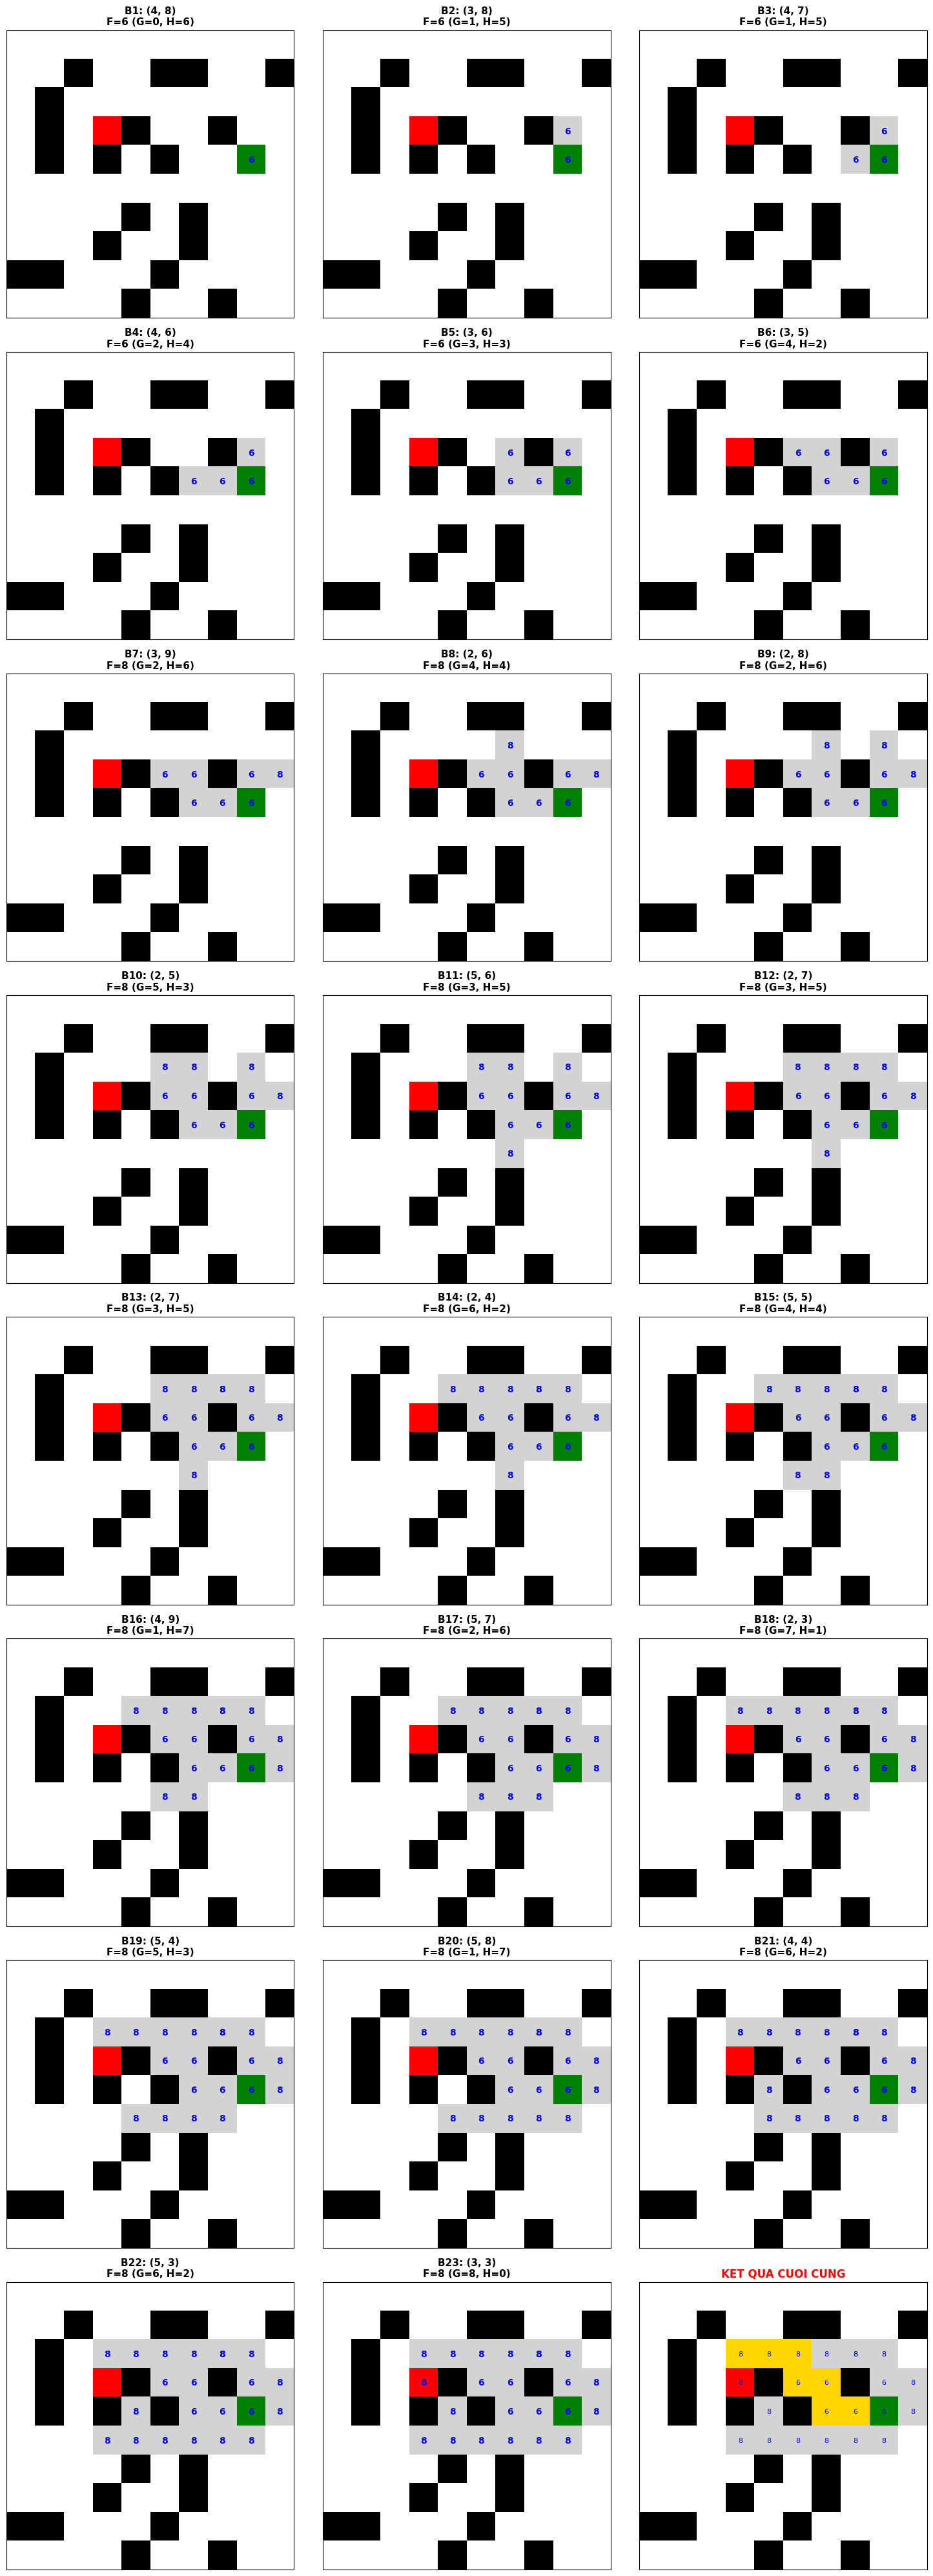

In [49]:
import math
import matplotlib.pyplot as plt
import numpy as np


def visualize_search_history_grid(maze, visited_history, final_path, max_cols=3):
    '''
    Hiển thị quá trình tìm kiếm A* trên lưới mê cung.
    Args:
        - maze: MazeMap object.
        - visited_history: Danh sách các bước đã thăm với thông tin g, h, f.
        - final_path: Danh sách tọa độ của đường đi cuối cùng nếu tìm thấy, else None.
        - max_cols: Số cột tối đa trong lưới hình ảnh.
    '''
    n = maze.n
    total_steps = len(visited_history)
    
    indices_to_draw = list(range(total_steps))
    num_plots = len(indices_to_draw) + 1 
    
    cols = max_cols
    rows = math.ceil(num_plots / cols)
    
    fig_width = cols * 5   
    fig_height = rows * 5
    
    if total_steps > 60:
        print(f"So luong buoc duyet lon ({total_steps}). Hinh anh se rat dai.")

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    
    if num_plots > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    base_data = np.zeros((n, n))
    for r in range(n):
        for c in range(n):
            if maze.grid[r][c].is_obstacle:
                base_data[r][c] = 1
    
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'green', 'red', 'lightgray', 'gold'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # --- VẼ TỪNG BƯỚC ---
    for idx, step_idx in enumerate(indices_to_draw):
        ax = axes_flat[idx]
        data = base_data.copy()
        
        current_history = visited_history[:step_idx+1]
        
        for item in current_history:
            r, c = item['pos']
            data[r][c] = 4 
            
        data[maze.start[0]][maze.start[1]] = 2
        data[maze.goal[0]][maze.goal[1]] = 3
        
        ax.imshow(data, cmap=cmap, norm=norm)
        
        for item in current_history:
            r, c = item['pos']
            f_val = int(item['f'])
            ax.text(c, r, str(f_val), ha='center', va='center', 
                    color='blue', fontsize=10, fontweight='bold')

        curr_node = visited_history[step_idx]
        title_str = f"B{step_idx+1}: {curr_node['pos']}\nF={int(curr_node['f'])} (G={int(curr_node['g'])}, H={int(curr_node['h'])})"
        ax.set_title(title_str, fontsize=11, fontweight='bold')
        ax.set_xticks([]); ax.set_yticks([]) 
        ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)

    # --- VẼ KẾT QUẢ CUỐI CÙNG ---
    ax_final = axes_flat[len(indices_to_draw)]
    data = base_data.copy()
    
    for item in visited_history:
        r, c = item['pos']
        data[r][c] = 4
        ax_final.text(c, r, str(int(item['f'])), ha='center', va='center', 
                      color='blue', fontsize=8)
    
    if final_path:
        for r, c in final_path:
            data[r][c] = 5 
            
    data[maze.start[0]][maze.start[1]] = 2
    data[maze.goal[0]][maze.goal[1]] = 3
    
    ax_final.imshow(data, cmap=cmap, norm=norm)
    ax_final.set_title("KET QUA CUOI CUNG", fontsize=12, color='red', fontweight='bold')
    ax_final.set_xticks([]); ax_final.set_yticks([])
    ax_final.grid(which='major', color='gray', linestyle='-', linewidth=0.5)

    for i in range(num_plots, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()

# --- HÀM HỖ TRỢ NHẬP TỌA ĐỘ ---
def get_coordinate_input(prompt, limit_n):
    """
    Nhận tọa độ từ người dùng dưới dạng 'row,col' hoặc 'row col'.
    Trả về tuple (row, col) hoặc None nếu nhập rỗng.
    Args:
        prompt: Chuỗi nhắc nhập.
        limit_n: Giới hạn kích thước lưới (0 đến limit_n-1).
    Returns: Tuple (row, col) hoặc None.
    """
    raw = input(prompt)
    if not raw.strip():
        return None
    
    try:
        # Thay thế dấu phẩy bằng dấu cách để xử lý cả '0,0' và '0 0'
        raw = raw.replace(',', ' ')
        parts = raw.split()
        if len(parts) >= 2:
            r, c = int(parts[0]), int(parts[1])
            # Kiểm tra biên
            if 0 <= r < limit_n and 0 <= c < limit_n:
                return (r, c)
            else:
                print(f"[LOI] Toa do phai nam trong khoang 0 - {limit_n-1}")
                return None
        return None
    except ValueError:
        print("[LOI] Dinh dang khong hop le.")
        return None

# --- HAM CHAY CHINH ---
def run_astar_interactive():
    print("=== CAU HINH INPUT A* ===")
    
    try:
        val_n = input("1. Nhap kich thuoc N (Mac dinh 10): ")
        n = 10 if not val_n.strip() else int(val_n)
        if n > 20: n = 20
        if n < 5: n = 5
        
        val_d = input("2. Nhap mat do vat can (Mac dinh 0.2): ")
        density = 0.2 if not val_d.strip() else float(val_d)
        if density < 0: density = 0
        if density > 0.7: density = 0.7
        
        # Nhập tọa độ Start/Goal
        print(f"Nhap toa do dang 'hang,cot' (vi du: 0,0). Enter de Random.")
        start_in = get_coordinate_input("3. Nhap toa do START (Enter de Random): ", n)
        goal_in = get_coordinate_input("4. Nhap toa do GOAL (Enter de Random): ", n)
            
    except ValueError:
        print("Nhap lieu sai! Dung gia tri mac dinh.")
        n = 10; density = 0.2; start_in = None; goal_in = None

    print("\nDang khoi tao ban do...")
    maze = MazeMap(n)
    
    # GỌI HÀM SINH MAP VỚI THAM SỐ START/GOAL
    maze.generate_random_map(density, manual_start=start_in, manual_goal=goal_in)

    # --- IN THONG TIN INPUT ---
    print("-" * 40)
    print("THONG TIN BAN DO:")
    print(f"   - Kich thuoc luoi:     {n} x {n}")
    print(f"   - Mat do vat can:      {density * 100}%")
    print(f"   - Diem Start (Xanh):   {maze.start} {'(Tu chon)' if start_in else '(Random)'}")
    print(f"   - Diem Goal (Do):      {maze.goal} {'(Tu chon)' if goal_in else '(Random)'}")
    print("-" * 40)
    
    print("Dang chay thuat toan A*...")
    solver = AStarSolver(maze)
    path, history = solver.solve()
    
    # --- IN LOG ---
    print("\n" + "="*50)
    print(f"{'BUOC':<6} | {'TOA DO (H,C)':<12} | {'G':<4} | {'H':<4} | {'F (G+H)':<8}")
    print("-" * 50)
    
    for i, item in enumerate(history):
        pos_str = str(item['pos'])
        print(f"{i+1:<6} | {pos_str:<12} | {int(item['g']):<4} | {int(item['h']):<4} | {int(item['f']):<8}")
    print("="*50 + "\n")

    if path:
        print(f"-> Da tim thay duong di! Do dai: {len(path)-1} buoc.")
    else:
        print("-> KHONG tim thay duong di!")
        
    print("-> Dang ve chi tiet tung buoc xu ly...")
    visualize_search_history_grid(maze, history, path, max_cols=3)

# Gọi hàm chạy
run_astar_interactive()